## Vehicle Detection Project Arturo Polanco Lozano

The goals / steps of this project are the following:

    Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
    Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
    Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
    Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
    Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
    Estimate a bounding box for vehicles detected.


## Histogram of Oriented Gradients (HOG)
1. Explain how (and identify where in your code) you extracted HOG features from the training images.

The code for this step is contained in the first code cell of the IPython notebook (or in lines # through # of the file called some_file.py).

I started by reading in all the vehicle and non-vehicle images. Here is an example of one of each of the vehicle and non-vehicle classes:

In [9]:
import numpy as np
import cv2
import glob
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label
import pickle
from functions import *
print("Packages imported")

Packages imported


In [2]:
# read in cars and notcars
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')

# check that arrays are not empty
print(cars[0])
print(notcars[0])

vehicles/GTI_Far/image0254.png
non-vehicles/GTI/image1894.png


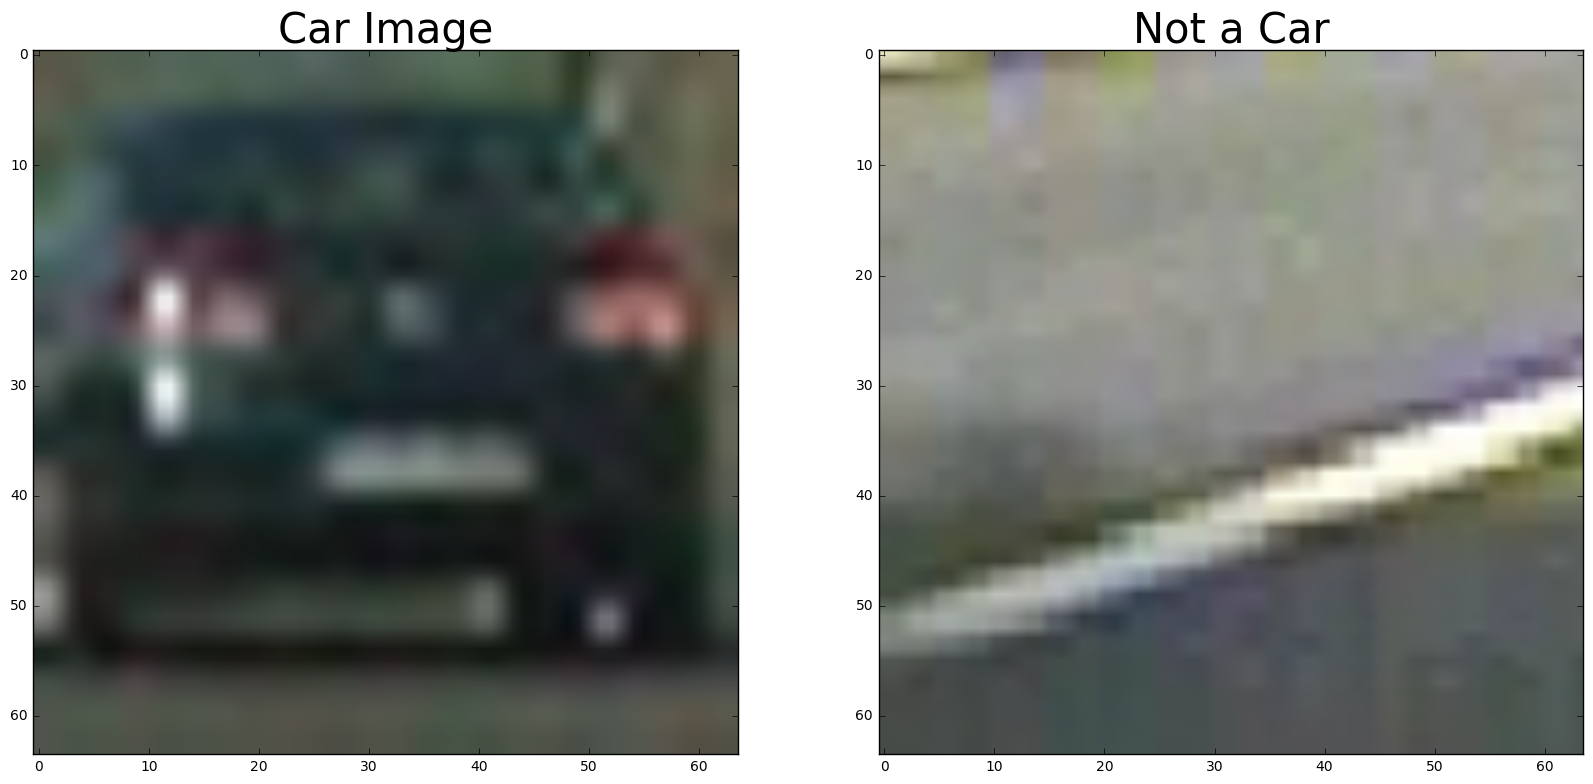

In [3]:
car = mpimg.imread(cars[0])
nocar = mpimg.imread(notcars[1])
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(car)
ax1.set_title('Car Image', fontsize=30)
ax2.imshow(nocar)
ax2.set_title('Not a Car', fontsize=30)

In [4]:
print("Number of Vehicle Images Found: ",len(cars))
print("Number of Non-Vehicle Images Found: ",len(notcars))

Number of Vehicle Images Found:  8792
Number of Non-Vehicle Images Found:  8968


In [5]:
# Define a function for plotting multiple images
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

Car image:  453
Not Car image:  6235


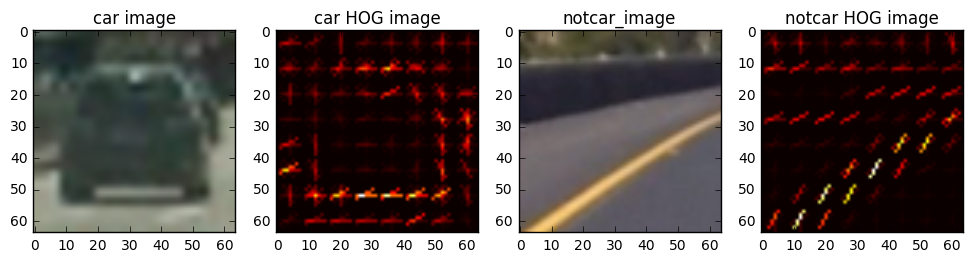

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

# choose random car - not random car indices
car_ind = np.random.randint(0, len(cars))
print("Car image: ",car_ind)
notcar_ind = np.random.randint(0, len(notcars))
print("Not Car image: ",notcar_ind)

# read in car - not car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# define feature parameters
color_space = 'RGB'
orient = 6
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0
spatial_size = (16, 16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

car_features, car_hog_image = single_img_features(car_image, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=True)
notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=True)

    

images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car image', 'car HOG image', 'notcar_image', 'notcar HOG image']
fig = plt.figure(figsize=(12, 3))            
visualize(fig, 1, 4, images, titles)

In [ ]:

# Define feature parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off   

t=time.time()
n_samples = 1000
random_idxs = np.random.randint(0, len(cars), n_samples)
test_cars = cars#np.array(cars)[random_idxs]
test_notcars = notcars#np.array(notcars)[random_idxs]

car_features = extract_features(test_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(test_notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


print(time.time()-t, 'Seconds to compute features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:',orient,'orientations,',pix_per_cell,
    'pixels per cell,', cell_per_block,'cells per block,',
     hist_bins,'histogram bins, and', spatial_size,'spatial sampling')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
print(round(time.time()-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

svc_dict = {'svc':svc, 'scaler':X_scaler, 'orient':orient, 'pix_per_cell':pix_per_cell, 
            'cell_per_block':cell_per_block, 'spatial_size':spatial_size, 'hist_bins':hist_bins}
pickle.dump(svc_dict, open("pickle.p", "wb" ) )

183.00949835777283 Seconds to compute features...


In [16]:
# Main class to generate video output

from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import cv2



# Load up saved data from SVM post training
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

# Define the y range to search for cars
ystart = 400
ystop = 656
# Save off heatmaps and car detected
heatmaps = []
carslist = []

# Function used to sync new detections with existing saved car detections
def Sync(captured, carlist):


	#print('used for debugging: start sync')
	#print('caps ',len(captured))
	#print('cars ',len(carlist))

	# If no cars add any detections as a new vehicle and put in carlist
	if len(carlist) == 0:
		for capture in captured:
			carlist.append(vehicle(capture[0],capture[1],capture[2],capture[3]))

	# If no captures but carlist is not empty then demote all vehicle detections
	elif len(captured) == 0:
		for car in carlist:
			if car.NegUpdate():
				carlist.remove(car)

	# Both carlist and new detections are non-empty and need to do comparisons to pair results
	else:
		# Keep track of what captures need to be made into a new vehicle
		capture_update = np.zeros((len(captured)))
		# Keep track of what cars need to get demoted because they didnt have a new track
		remove_update = np.zeros((len(carlist)))
		# Create a table to keep track of how new captures and existing captures relate
		# new captures are stored on the rows and exisitng captures on the columbs
		# The values we are storing between a new/old caputre pair is the rank defined as distance between positions
		grid = np.zeros((len(captured),len(carlist)+1))

		# Iterate through new captures
		for x in range(len(captured)):
			# Iterate through old captures
			for o in range(len(carlist)):
				# Measure the distance between new capture and all old captures
				grid[x,o] = carlist[o].Rank(captured[x][0],captured[x][1])
			# Store the old capture that was closest to the new capture 
			grid[x,len(carlist)] = np.argmin(grid[x][:-1])
		# Iterate through old captures
		for o in range(len(carlist)):
			# Iterate through new captures
			for x in range(len(captured)):
				# Mark all ranks as very high if new/old capture pair didnt match
				if grid[x][-1] != o:
					grid[x,o] = 1000

			# If the rank is good between new/old capture pair
			if np.amin(grid[:,o]) < 1000:
				# Establish a link to new/old capture and update new detected positon and window dimensions
				get_capture = captured[np.argmin(grid[:,o])]
				carlist[o].PosUpdate(get_capture[0],get_capture[1],get_capture[2],get_capture[3])
				capture_update[np.argmin(grid[:,o])] = 1
			else:
				# Else old capture did not have a new capture
				remove_update[o] = 1
		# Check what new captures did not have a matched old capture and create a new vehicle out of it, and add it in carlist
		for i in range(len(capture_update)):
			if capture_update[i] == 0:
				get_capture = captured[i]
				carlist.append(vehicle(get_capture[0],get_capture[1],get_capture[2],get_capture[3]))

		# Look through old captures that did not have a new capture and demote them, if the negtative detections in a row is
		# greater than some threshold we delete the old capture from the carlist
		remove_index = []
		for car in range(len(remove_update)):
			if remove_update[car] == 1 and carlist[car].NegUpdate():
				remove_index.append(car)

		carlist = np.delete(carlist,remove_index)
		carlist = carlist.tolist()

	return carlist

# Process each frame of the video
def process_image(image):
	# We want to modify carslist and heatmaps from this function
	global carslist, heatmaps
	# Create a general heatmap
	heatmap = np.zeros_like(image[:,:,0])
	# Iterate through different scale values
	for scale in np.arange(1,2.1,.2):
		# Create heat maps for different scales in function to both search and classify
		out_img, heat_map = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
		# Add heat to heatmap from different scales
		heatmap += heat_map
	
	# Add general heatmap to list of heatmaps
	heatmaps.append(heatmap)
	# Sum togehter the last 5 frame heatmaps into 1 heatmap
	heatmap = seriesHeatmap(image,5)
	# Use threshold to help remove false positives from heatmap
	heatmap = apply_threshold(heatmap,5)
	# Get the box positions from heatmap
	labels = label(heatmap)

	# Store box parameters for each box as a new capture
	captured = []
	for car_number in range(1, labels[1]+1):
		nonzero = (labels[0] == car_number).nonzero()
		nonzeroy = np.array(nonzero[0])
		nonzerox = np.array(nonzero[1])

		xpos = np.min(nonzerox)
		ypos = np.min(nonzeroy)

		width = np.max(nonzerox)-xpos
		height = np.max(nonzeroy)-ypos

		captured.append([xpos,ypos,width,height])

	# Sync old captures with new captures
	carslist = Sync(captured,carslist)

	# Draw bounding boxes on a copy of the image
	draw_img = draw_labeled_bboxes(np.copy(image), carslist)

	return draw_img

def draw_labeled_bboxes(img, carlist):
    # Iterate through all detected cars
    for car_number in range(len(carlist)):

    	if carlist[car_number].detected:
    		bbox = carlist[car_number].Box()
    		# Draw the box on the image
    		cv2.rectangle(img, bbox[0], bbox[1], (255, 0, 0), 5) 
    # Return the image
    return img
		
def seriesHeatmap(refimg,nframe):
	heatmap = np.zeros_like(refimg[:,:,0])
	nframe = min(5,len(heatmaps))
	for i in np.arange(1,nframe):
		heatmap += heatmaps[-i]
	return heatmap


video_output = 'track2.mp4'
Input_video = 'project_video.mp4'
clip1 = VideoFileClip(Input_video)
video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video tracked2.mp4
[MoviePy] Writing video tracked2.mp4


100%|█████████▉| 1260/1261 [1:09:08<00:03,  3.42s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: tracked2.mp4 



In [7]:
import math
import numpy as np

class vehicle():
    def __init__(self, x_position, y_position, width, height, smooth_factor=5):
        self.detected = False  # is vehicle active, only draw vehicle if active
         # Store all vehciles history of x,y positions and width/height
        self.x_positions = []
        self.x_positions.append(x_position)
        self.y_positions = []
        self.y_positions.append(y_position)
        self.width = []
        self.width.append(width)
        self.height = []
        self.height.append(height)
        # Define a smoothing factor to average past x,y positions and width/height
        self.smooth_factor = smooth_factor

        self.n_detections = 1 # Number of consecutive times this vehicle has been detected?
        self.n_nondetections = 0 # Number of consecutive times this car has not been detected since last detection
    
    # Return the distance between the vehicles position and some input capture's position
    def Rank(self, x_position, y_position):
        rank = math.sqrt((x_position-self.x_positions[-1])**2+(y_position-self.y_positions[-1])**2)
        # threshold the max distance to consider a link
        if rank < 50: 
            return rank
        else:
            return 1000

    # Update the vehicle with new pos/dim
    def PosUpdate(self, x_position, y_position, width, height):
        self.x_positions.append(x_position)
        self.y_positions.append(y_position)
        self.width.append(width)
        self.height.append(height)

        self.n_detections+=1
        self.n_nondetections = 0
        if self.n_detections > 5:
            self.detected = True

    # Demote the vehicle because it didnt have a new caputre
    def NegUpdate(self): #return weather to remove vehicle
        self.n_nondetections+=1

        # If we dont see the vehicle for three frames in a row we delete it
        if self.n_nondetections > 3:
            return True
        return False

    # Check if vehicle was detected but had failed to be tracked 3 times in a row
    def CheckValid(self):
        if self.detected & self.n_nondetections > 3:
            return False
        else:
            return True

    # Average together all pos/dim and return the box that defines
    def Box(self):
        xpos = int(np.average(self.x_positions[-self.smooth_factor:], axis = 0))
        ypos = int(np.average(self.y_positions[-self.smooth_factor:], axis = 0))
        width = int(np.average(self.width[-self.smooth_factor:], axis = 0))
        height = int(np.average(self.height[-self.smooth_factor:], axis = 0))

        return ((xpos, ypos), (xpos+width, ypos+height))


In [15]:
# Main class to generate image output

import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
from skimage.feature import hog
import os, os.path
import pickle


# Load up saved data from SVM post training
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

example_images = glob.glob('./test_images/test*.jpg')

# Define the y range to search for cars
ystart = 400
ystop = 656
# Iterate over test images
for idx, img_src in enumerate(example_images):

	print("working on file ",idx)
	img = mpimg.imread(img_src)
	# Create a heatmap template
	heatmap = np.zeros_like(img[:,:,0])
	# Iterate through different scale values
	for scale in np.arange(1,2.1,.2):
		#print(scale)
		# Create heat maps for different scales in function to both search and classify
		out_img, heat_map = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
		heatmap += heat_map
	# Threshold the heatmap to get rid of false positives
	heatmap = apply_threshold(heatmap,3)
	labels = label(heatmap)
	# Draw bounding boxes on a copy of the image
	draw_img = draw_labeled_bboxes(np.copy(img), labels)

	# Fix cv2 image output
	r,g,b = cv2.split(draw_img)
	draw_img = cv2.merge((b,g,r))

	# Add some color to the heat map and scale it
	zero_channel = np.zeros_like(heatmap)
	heatmap = heatmap*20
	heatmap = cv2.merge((zero_channel,zero_channel,heatmap))

	# Save the output for car box locations and heatmaps
	write_name = './output_images/tracked'+str(idx)+'.jpg'
	cv2.imwrite(write_name, draw_img)

	write_name = './output_images/heatmap'+str(idx)+'.jpg'
	cv2.imwrite(write_name, heatmap)

working on file  0
working on file  1
working on file  2
working on file  3
working on file  4
working on file  5


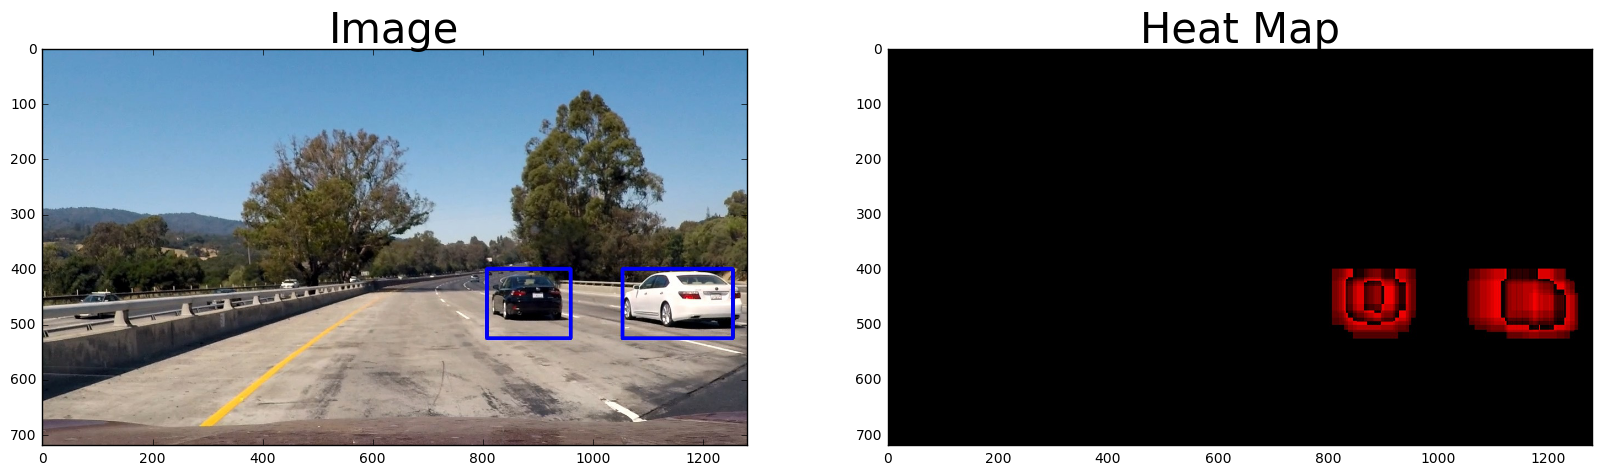

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
# read in cars and notcars
import glob
heat_map_images_out = glob.glob('output_images/*.jpg')


car = mpimg.imread('output_images/im0.jpg')
nocar = mpimg.imread('output_images/im01.jpg')
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(car)
ax1.set_title('Image', fontsize=30)
ax2.imshow(nocar)
ax2.set_title('Heat Map', fontsize=30)
    